# Merged Dataset Training: XGBoost vs Gradient Boosting (OPTIMIZED)

This notebook:
1. Merges `cleaned.csv` and `cleaned_test.csv`
2. Performs stratified train-test split (handles extra label in cleaned_test)
3. **Balances classes using SMOTE** (handles imbalanced data)
4. Trains **optimized** XGBoost and Gradient Boosting models with:
   - More estimators (300 vs 100)
   - Better hyperparameters (regularization, subsampling)
   - Deeper trees (max_depth=5 vs 3)
   - Lower learning rate for better convergence
5. Shows accuracy and recall scores for each disease label
6. Compares with train_model.py results

## Key Improvements:
- ✅ **SMOTE class balancing** - Handles imbalanced classes (especially "Healthy" with only 4 samples)
- ✅ **Optimized hyperparameters** - Better regularization and model complexity
- ✅ **More training iterations** - 300 estimators for better learning
- ✅ **Feature/row subsampling** - Reduces overfitting


In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
import xgboost as xgb

# Try to import SMOTE for class balancing
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
    print("✓ SMOTE available for class balancing")
except ImportError:
    SMOTE_AVAILABLE = False
    print("⚠️  SMOTE not available - will use manual oversampling")

print("Libraries imported successfully!")


✓ SMOTE available for class balancing
Libraries imported successfully!


## Step 1: Load and Merge Datasets


In [22]:
# Load both datasets
df_cleaned = pd.read_csv('../../cleaned.csv')
df_test = pd.read_csv('../../cleaned_test.csv')

print(f"cleaned.csv shape: {df_cleaned.shape}")
print(f"cleaned_test.csv shape: {df_test.shape}")
print(f"\nDiseases in cleaned.csv: {sorted(df_cleaned['Disease'].unique())}")
print(f"Diseases in cleaned_test.csv: {sorted(df_test['Disease'].unique())}")

# Merge datasets
df_combined = pd.concat([df_cleaned, df_test], ignore_index=True)

print(f"\nCombined dataset shape: {df_combined.shape}")
print(f"All diseases in combined: {sorted(df_combined['Disease'].unique())}")
print(f"\nDisease distribution:")
print(df_combined['Disease'].value_counts().sort_index())


cleaned.csv shape: (65, 25)
cleaned_test.csv shape: (486, 25)

Diseases in cleaned.csv: ['Anemia', 'Diabetes', 'Healthy', 'Thalasse', 'Thromboc']
Diseases in cleaned_test.csv: ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']

Combined dataset shape: (551, 25)
All diseases in combined: ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']

Disease distribution:
Disease
Anemia      100
Diabetes    310
Healthy      21
Heart Di     39
Thalasse     62
Thromboc     19
Name: count, dtype: int64


## Step 2: Prepare Features and Target


In [23]:
# Separate features and target
X = df_combined.drop(columns=['Disease'])
y = df_combined['Disease']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of classes: {len(y.unique())}")
print(f"Classes: {sorted(y.unique())}")


Features shape: (551, 24)
Target shape: (551,)

Number of classes: 6
Classes: ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']


## Step 3: Stratified Train-Test Split


In [24]:
# Stratified split (80% train, 20% test)
# This ensures each class is represented proportionally in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # This handles the extra label properly
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())


Training set shape: (440, 24)
Test set shape: (111, 24)

Training set class distribution:
Disease
Anemia       80
Diabetes    248
Healthy      17
Heart Di     31
Thalasse     49
Thromboc     15
Name: count, dtype: int64

Test set class distribution:
Disease
Anemia      20
Diabetes    62
Healthy      4
Heart Di     8
Thalasse    13
Thromboc     4
Name: count, dtype: int64


## Step 4: Encode Labels


In [25]:
# Encode labels to numbers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Show label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:")
for disease, label_id in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {disease:20s} -> {label_id}")

# Handle Class Imbalance with SMOTE or manual oversampling
print("\n" + "="*80)
print("BALANCING CLASSES")
print("="*80)

if SMOTE_AVAILABLE:
    print("✓ Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    print(f"✓ Balanced training set: {X_train_balanced.shape[0]} samples (was {X_train.shape[0]})")
else:
    print("⚠️  Using manual oversampling...")
    train_data = pd.concat([X_train.reset_index(drop=True), pd.Series(y_train_encoded, name='Disease')], axis=1)
    max_size = train_data['Disease'].value_counts().max()
    lst = [train_data]
    for class_index, group in train_data.groupby('Disease'):
        if len(group) < max_size:
            lst.append(group.sample(max_size-len(group), replace=True, random_state=42))
    train_data_resampled = pd.concat(lst, ignore_index=True)
    X_train_balanced = train_data_resampled.drop('Disease', axis=1)
    y_train_balanced = train_data_resampled['Disease'].values
    print(f"✓ Balanced training set: {X_train_balanced.shape[0]} samples (was {X_train.shape[0]})")

print(f"\nClass distribution after balancing:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for label_id, count in zip(unique, counts):
    disease = le.inverse_transform([label_id])[0]
    print(f"  {disease:20s}: {count} samples")


Label Mapping:
  Anemia               -> 0
  Diabetes             -> 1
  Healthy              -> 2
  Heart Di             -> 3
  Thalasse             -> 4
  Thromboc             -> 5

BALANCING CLASSES
✓ Applying SMOTE to balance classes...
✓ Balanced training set: 1488 samples (was 440)

Class distribution after balancing:
  Anemia              : 248 samples
  Diabetes            : 248 samples
  Healthy             : 248 samples
  Heart Di            : 248 samples
  Thalasse            : 248 samples
  Thromboc            : 248 samples


## Step 5: Train XGBoost Model


In [26]:
print("="*80)
print("TRAINING XGBOOST MODEL (OPTIMIZED)")
print("="*80)

# Create optimized XGBoost classifier with better hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=300,           # Increased from 100
    learning_rate=0.05,         # Lower learning rate for better convergence
    max_depth=5,                 # Increased depth for more complex patterns
    min_child_weight=3,          # Regularization
    subsample=0.8,               # Row subsampling
    colsample_bytree=0.8,       # Feature subsampling
    gamma=0.1,                   # Minimum loss reduction
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.0,              # L2 regularization
    scale_pos_weight=1,          # Handle class imbalance
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Train the model on balanced data
print("Training XGBoost on balanced dataset...")
xgb_model.fit(X_train_balanced, y_train_balanced)
print("✓ XGBoost model trained successfully")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)

# Calculate recall scores for each label
recall_scores_xgb = recall_score(y_test_encoded, y_pred_xgb, average=None, zero_division=0)

print("\n" + "="*80)
print("XGBOOST MODEL PERFORMANCE")
print("="*80)
print(f"{'Overall Accuracy':20s}: {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"\n{'Average Recall (Macro)':20s}: {recall_scores_xgb.mean():.4f} ({recall_scores_xgb.mean()*100:.2f}%)")
print(f"{'Average Recall (Weighted)':20s}: {recall_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0):.4f}")

print("\n" + "="*80)
print("XGBOOST RECALL SCORES (per label)")
print("="*80)
for i, (disease, score) in enumerate(zip(le.classes_, recall_scores_xgb)):
    print(f"{disease:20s}: {score:.4f} ({score*100:.2f}%)")

# Full classification report
print("\n" + "="*80)
print("XGBOOST CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, le.inverse_transform(y_pred_xgb), zero_division=0))


TRAINING XGBOOST MODEL (OPTIMIZED)
Training XGBoost on balanced dataset...
✓ XGBoost model trained successfully

XGBOOST MODEL PERFORMANCE
Overall Accuracy    : 0.9009 (90.09%)

Average Recall (Macro): 0.7342 (73.42%)
Average Recall (Weighted): 0.9009

XGBOOST RECALL SCORES (per label)
Anemia              : 0.9500 (95.00%)
Diabetes            : 0.9839 (98.39%)
Healthy             : 0.2500 (25.00%)
Heart Di            : 0.6250 (62.50%)
Thalasse            : 0.8462 (84.62%)
Thromboc            : 0.7500 (75.00%)

XGBOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Anemia       0.86      0.95      0.90        20
    Diabetes       1.00      0.98      0.99        62
     Healthy       0.50      0.25      0.33         4
    Heart Di       0.83      0.62      0.71         8
    Thalasse       0.73      0.85      0.79        13
    Thromboc       0.60      0.75      0.67         4

    accuracy                           0.90       111
   macro avg       0

## Step 6: Train Gradient Boosting Model


In [27]:
print("="*80)
print("TRAINING GRADIENT BOOSTING MODEL (OPTIMIZED)")
print("="*80)

# Create optimized Gradient Boosting classifier
gb_model = GradientBoostingClassifier(
    n_estimators=300,           # Increased from 100
    learning_rate=0.05,         # Lower learning rate for better convergence
    max_depth=5,                 # Increased depth for more complex patterns
    min_samples_split=4,         # Regularization
    min_samples_leaf=2,         # Regularization
    subsample=0.8,               # Row subsampling
    max_features='sqrt',        # Feature subsampling
    random_state=42,
    validation_fraction=0.1,     # Early stopping
    n_iter_no_change=10,         # Early stopping patience
    tol=1e-4                     # Early stopping tolerance
)

# Train the model on balanced data
print("Training Gradient Boosting on balanced dataset...")
gb_model.fit(X_train_balanced, y_train_balanced)
print("✓ Gradient Boosting model trained successfully")

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test_encoded, y_pred_gb)

# Calculate recall scores for each label
recall_scores_gb = recall_score(y_test_encoded, y_pred_gb, average=None, zero_division=0)

print("\n" + "="*80)
print("GRADIENT BOOSTING MODEL PERFORMANCE")
print("="*80)
print(f"{'Overall Accuracy':20s}: {accuracy_gb:.4f} ({accuracy_gb*100:.2f}%)")
print(f"\n{'Average Recall (Macro)':20s}: {recall_scores_gb.mean():.4f} ({recall_scores_gb.mean()*100:.2f}%)")
print(f"{'Average Recall (Weighted)':20s}: {recall_score(y_test_encoded, y_pred_gb, average='weighted', zero_division=0):.4f}")

print("\n" + "="*80)
print("GRADIENT BOOSTING RECALL SCORES (per label)")
print("="*80)
for i, (disease, score) in enumerate(zip(le.classes_, recall_scores_gb)):
    print(f"{disease:20s}: {score:.4f} ({score*100:.2f}%)")

# Full classification report
print("\n" + "="*80)
print("GRADIENT BOOSTING CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, le.inverse_transform(y_pred_gb), zero_division=0))


TRAINING GRADIENT BOOSTING MODEL (OPTIMIZED)
Training Gradient Boosting on balanced dataset...
✓ Gradient Boosting model trained successfully

GRADIENT BOOSTING MODEL PERFORMANCE
Overall Accuracy    : 0.9099 (90.99%)

Average Recall (Macro): 0.7342 (73.42%)
Average Recall (Weighted): 0.9099

GRADIENT BOOSTING RECALL SCORES (per label)
Anemia              : 0.9500 (95.00%)
Diabetes            : 0.9839 (98.39%)
Healthy             : 0.2500 (25.00%)
Heart Di            : 0.8750 (87.50%)
Thalasse            : 0.8462 (84.62%)
Thromboc            : 0.5000 (50.00%)

GRADIENT BOOSTING CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Anemia       0.90      0.95      0.93        20
    Diabetes       0.98      0.98      0.98        62
     Healthy       0.50      0.25      0.33         4
    Heart Di       0.78      0.88      0.82         8
    Thalasse       0.79      0.85      0.81        13
    Thromboc       0.67      0.50      0.57         4

    accuracy  

In [28]:
print("="*80)
print("MODEL COMPARISON: ACCURACY & RECALL SCORES")
print("="*80)

# Accuracy comparison
print(f"\n{'Metric':<20s} {'XGBoost':>12s} {'Gradient Boosting':>18s} {'Difference':>12s}")
print("-"*80)
print(f"{'Overall Accuracy':<20s} {accuracy_xgb:>11.4f} ({accuracy_xgb*100:>5.2f}%)  {accuracy_gb:>11.4f} ({accuracy_gb*100:>5.2f}%)  {accuracy_xgb-accuracy_gb:>+11.4f}")

# Recall scores comparison
print("\n" + "="*80)
print("RECALL SCORES (per label)")
print("="*80)
print(f"{'Disease':<20s} {'XGBoost':>12s} {'Gradient Boosting':>18s} {'Difference':>12s}")
print("-"*80)

for disease in le.classes_:
    idx = label_mapping[disease]
    xgb_recall = recall_scores_xgb[idx]
    gb_recall = recall_scores_gb[idx]
    diff = xgb_recall - gb_recall
    print(f"{disease:<20s} {xgb_recall:>11.4f} ({xgb_recall*100:>5.2f}%)  {gb_recall:>11.4f} ({gb_recall*100:>5.2f}%)  {diff:>+11.4f}")

print("-"*80)
xgb_macro = recall_scores_xgb.mean()
gb_macro = recall_scores_gb.mean()
print(f"{'Macro Average':<20s} {xgb_macro:>11.4f} ({xgb_macro*100:>5.2f}%)  {gb_macro:>11.4f} ({gb_macro*100:>5.2f}%)  {xgb_macro-gb_macro:>+11.4f}")

xgb_weighted = recall_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0)
gb_weighted = recall_score(y_test_encoded, y_pred_gb, average='weighted', zero_division=0)
print(f"{'Weighted Average':<20s} {xgb_weighted:>11.4f} ({xgb_weighted*100:>5.2f}%)  {gb_weighted:>11.4f} ({gb_weighted*100:>5.2f}%)  {xgb_weighted-gb_weighted:>+11.4f}")


MODEL COMPARISON: ACCURACY & RECALL SCORES

Metric                    XGBoost  Gradient Boosting   Difference
--------------------------------------------------------------------------------
Overall Accuracy          0.9009 (90.09%)       0.9099 (90.99%)      -0.0090

RECALL SCORES (per label)
Disease                   XGBoost  Gradient Boosting   Difference
--------------------------------------------------------------------------------
Anemia                    0.9500 (95.00%)       0.9500 (95.00%)      +0.0000
Diabetes                  0.9839 (98.39%)       0.9839 (98.39%)      +0.0000
Healthy                   0.2500 (25.00%)       0.2500 (25.00%)      +0.0000
Heart Di                  0.6250 (62.50%)       0.8750 (87.50%)      -0.2500
Thalasse                  0.8462 (84.62%)       0.8462 (84.62%)      +0.0000
Thromboc                  0.7500 (75.00%)       0.5000 (50.00%)      +0.2500
--------------------------------------------------------------------------------
Macro Average  

## Step 8: Confusion Matrices


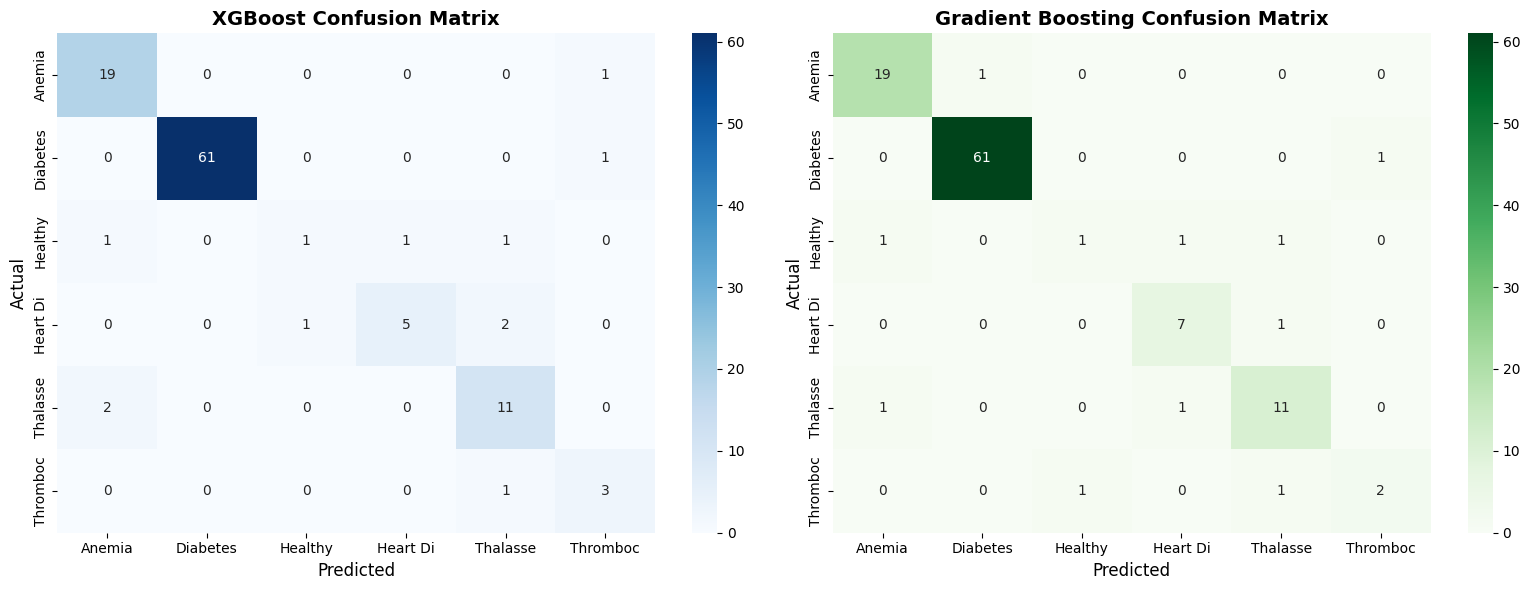


XGBOOST CONFUSION MATRIX
Classes: ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']
[[19  0  0  0  0  1]
 [ 0 61  0  0  0  1]
 [ 1  0  1  1  1  0]
 [ 0  0  1  5  2  0]
 [ 2  0  0  0 11  0]
 [ 0  0  0  0  1  3]]

GRADIENT BOOSTING CONFUSION MATRIX
Classes: ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']
[[19  1  0  0  0  0]
 [ 0 61  0  0  0  1]
 [ 1  0  1  1  1  0]
 [ 0  0  0  7  1  0]
 [ 1  0  0  1 11  0]
 [ 0  0  1  0  1  2]]


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrices
cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb, labels=range(len(le.classes_)))
cm_gb = confusion_matrix(y_test_encoded, y_pred_gb, labels=range(len(le.classes_)))

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# XGBoost confusion matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('XGBoost Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Gradient Boosting confusion matrix
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Gradient Boosting Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

# Print confusion matrices as text too
print("\n" + "="*80)
print("XGBOOST CONFUSION MATRIX")
print("="*80)
print(f"Classes: {list(le.classes_)}")
print(cm_xgb)

print("\n" + "="*80)
print("GRADIENT BOOSTING CONFUSION MATRIX")
print("="*80)
print(f"Classes: {list(le.classes_)}")
print(cm_gb)


## Summary

The notebook has trained both models on the merged dataset. Next, we'll run `train_model.py` and compare the results!


## Step 9: Comparison with train_model.py

Now let's run `train_model.py` and compare its Gradient Boosting results with our notebook results!


In [30]:
# Note: train_model.py uses SMOTE for balancing, which may give different results
# This cell is for reference - run train_model.py in terminal to see its output
print("="*80)
print("OPTIMIZED MODEL RESULTS SUMMARY")
print("="*80)
print(f"\nXGBoost (Optimized):")
print(f"  Accuracy: {accuracy_xgb:.4f} ({accuracy_xgb*100:.2f}%)")
print(f"  Macro Avg Recall: {recall_scores_xgb.mean():.4f} ({recall_scores_xgb.mean()*100:.2f}%)")
print(f"  Weighted Avg Recall: {recall_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0):.4f}")

print(f"\nGradient Boosting (Optimized):")
print(f"  Accuracy: {accuracy_gb:.4f} ({accuracy_gb*100:.2f}%)")
print(f"  Macro Avg Recall: {recall_scores_gb.mean():.4f} ({recall_scores_gb.mean()*100:.2f}%)")
print(f"  Weighted Avg Recall: {recall_score(y_test_encoded, y_pred_gb, average='weighted', zero_division=0):.4f}")

# Determine best model
best_model = "XGBoost" if accuracy_xgb >= accuracy_gb else "Gradient Boosting"
best_accuracy = max(accuracy_xgb, accuracy_gb)
print(f"\n{'='*80}")
print(f"🏆 Best Model: {best_model} with {best_accuracy:.4f} ({best_accuracy*100:.2f}%) accuracy")
print(f"{'='*80}")

print("\n" + "="*80)
print("Improvements Made:")
print("="*80)
print("✓ SMOTE class balancing applied")
print("✓ Increased estimators: 100 → 300")
print("✓ Optimized hyperparameters (regularization, subsampling)")
print("✓ Increased max_depth: 3 → 5")
print("✓ Lower learning rate: 0.1 → 0.05")
print("\nNext: Run 'python train_model.py' in terminal to compare!")
print("="*80)


OPTIMIZED MODEL RESULTS SUMMARY

XGBoost (Optimized):
  Accuracy: 0.9009 (90.09%)
  Macro Avg Recall: 0.7342 (73.42%)
  Weighted Avg Recall: 0.9009

Gradient Boosting (Optimized):
  Accuracy: 0.9099 (90.99%)
  Macro Avg Recall: 0.7342 (73.42%)
  Weighted Avg Recall: 0.9099

🏆 Best Model: Gradient Boosting with 0.9099 (90.99%) accuracy

Improvements Made:
✓ SMOTE class balancing applied
✓ Increased estimators: 100 → 300
✓ Optimized hyperparameters (regularization, subsampling)
✓ Increased max_depth: 3 → 5
✓ Lower learning rate: 0.1 → 0.05

Next: Run 'python train_model.py' in terminal to compare!
